In [3]:
import numpy as np
from magnitude_function import *
import torch
import matplotlib.pyplot as plt

In [4]:
# Download embeddings

EMB_PATH = "/workspace/mnt/local/data/pgurevich/magnitude/embeddings.pt"
LAB_PATH = "/workspace/mnt/local/data/pgurevich/magnitude/labels.pt"

embs = torch.load(EMB_PATH)
labs = torch.load(LAB_PATH)

/tmp/ipykernel_1596005/804649383.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embs = torch.load(EMB_PATH)
/tmp/ipykernel_1596005/804649383.py:7: FutureWarning: You ar

In [5]:
reals_inds = torch.where(labs == 0)[0]
generated_inds = torch.where(labs == 1)[0]

reals = embs[reals_inds]
gens = embs[generated_inds]


In [32]:
t = 0.1

real_mags = [calculate_magnitude(x * t, metric='cityblock') for x in tqdm(reals)]
gen_mags = [calculate_magnitude(x * t, metric='cityblock') for x in tqdm(gens)]

100%|██████████| 500/500 [00:31<00:00, 15.93it/s]


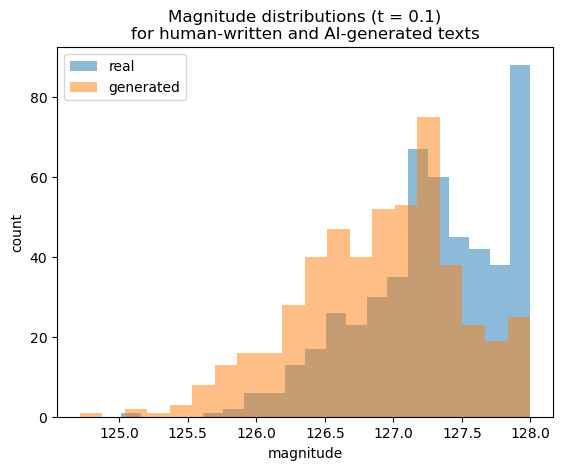

In [34]:
plt.hist(real_mags, alpha=0.5, label='real', bins=20)
plt.hist(gen_mags, alpha=0.5, label='generated', bins=20)
plt.legend()
plt.title(f"Magnitude distributions (t = {t})\nfor human-written and AI-generated texts")
plt.xlabel("magnitude")
plt.ylabel('count')
plt.show()

In [57]:
t = np.linspace(0.005, 0.04, 50)

real_mfs = [calculate_magnitude_function(x, 'cityblock', t) for x in reals]
gen_mfs = [calculate_magnitude_function(x, 'cityblock', t) for x in gens]

100%|██████████| 50/50 [00:03<00:00, 15.12it/s]


Text(0, 0.5, 'magnitude')

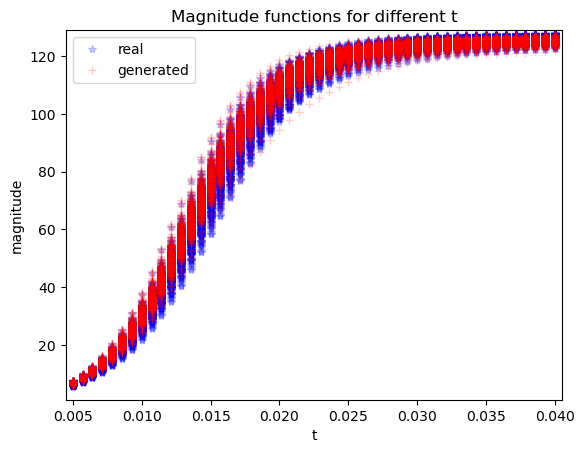

In [63]:
plt.title("Magnitude functions for different t")
l1 = plt.plot(t, np.array(real_mfs).T, 'b*', alpha=0.2, label='real')
l2 = plt.plot(t, np.array(gen_mfs).T,  "r+", alpha=0.2, label='generated')
plt.legend(handles=[l1[0], l2[0]])
plt.xlim(0.0045, 0.0405)
plt.ylim(1, 129)
plt.xlabel("t")
plt.ylabel("magnitude")

In [64]:
real_mfs = np.array(real_mfs)
gen_mfs = np.array(gen_mfs)

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold


def logreg(reals, gens, pca=False, n_splits=6):
    data = np.concatenate([reals, gens], axis=0)
    labels = np.zeros(len(reals) + len(gens))
    labels[len(reals):] = 1

    # Initialize StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=21)
    auc_scores = []

    for train_idx, val_idx in skf.split(data, labels):
        X_train, X_val = data[train_idx], data[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]

        # Standard Scaling (fit on training fold only)
        ss = StandardScaler()
        X_train_scaled = ss.fit_transform(X_train)
        X_val_scaled = ss.transform(X_val)

        # PCA if enabled (fit on scaled training fold only)
        if pca:
            pca_model = PCA(n_components=700, random_state=21)
            X_train_scaled = pca_model.fit_transform(X_train_scaled)
            X_val_scaled = pca_model.transform(X_val_scaled)

        # Train and evaluate model
        lr = LogisticRegression()
        lr.fit(X_train_scaled, y_train)
        val_preds = lr.predict_proba(X_val_scaled)[:, 1]
        fold_auc = roc_auc_score(y_val, val_preds)
        auc_scores.append(fold_auc)

    # Return mean AUC across all folds
    return np.mean(auc_scores)

In [95]:
logreg(real_mfs, gen_mfs)

np.float64(0.7906459458027175)

In [96]:
real_text_embs = reals.mean(dim=1).numpy()
gen_text_embs = gens.mean(dim=1).numpy()

logreg(real_text_embs, gen_text_embs), logreg(real_text_embs, gen_text_embs, pca=True)

(np.float64(0.9908305050379372), np.float64(0.9907115553435775))

In [97]:
real_text_and_mag = np.concatenate([real_text_embs, real_mfs], axis=1)
gen_text_and_mag = np.concatenate([gen_text_embs, gen_mfs], axis=1)

logreg(real_text_and_mag, gen_text_and_mag), logreg(real_text_and_mag, gen_text_and_mag, pca=True)

(np.float64(0.9911441520528471), np.float64(0.9909053886227642))